In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fredapi import Fred
import yfinance as yf
from dotenv import load_dotenv
import os


In [7]:
fred =Fred(os.getenv("fred_api"))

In [8]:
def series_fred(fred, series_dict):
    data= pd.DataFrame()
    for code, name in series_dict.items():
        data[name] = fred.get_series(code, frequency = 'm')
    return data


In [9]:
series={'SAHMCURRENT':'sahm_rule',
        'VIXCLS':'vix',
        'T10Y2Y':'T10Y2Y',
        'T10Y3M':'T10Y3M',
        'INDPRO':'INDPRO',
        'CPIAUCSL':'CPI',
        'PCE':'PCE'
        }

In [10]:
sp_500 = yf.download(tickers='^GSPC', start='1990-01-01', end='2025-10-05', interval='1mo', auto_adjust=True)['Close']
sp_500 = sp_500.round(4)

[*********************100%***********************]  1 of 1 completed


In [11]:
data = series_fred(fred, series)
data = pd.merge(data, sp_500, left_index=True, right_index=True, how='left')
data['sahm_dummy'] = (data['sahm_rule'] > 0.5).astype(int)
data['PCE'] = np.log(data['PCE'])
data = data.dropna(axis=0)
data

,sahm_rule,vix,T10Y2Y,T10Y3M,INDPRO,CPI,PCE,^GSPC,sahm_dummy
1990-01-01,0.27,23.35,0.12,0.31,61.6352,127.500,8.224351,329.0800,0
1990-02-01,0.23,23.26,0.10,0.47,62.1951,128.000,8.223681,331.8900,0
1990-03-01,0.17,20.06,-0.04,0.42,62.4916,128.600,8.230817,339.9400,0
1990-04-01,0.17,21.40,0.06,0.75,62.3511,128.900,8.234830,330.8000,0
1990-05-01,0.20,18.10,0.12,0.75,62.5353,129.100,8.236368,361.2300,0
...,...,...,...,...,...,...,...,...,...
2025-04-01,0.27,31.97,0.50,-0.04,103.6224,320.321,9.940128,5569.0601,0
2025-05-01,0.27,20.46,0.50,0.06,103.6570,320.580,9.940542,5911.6899,0
2025-06-01,0.17,18.40,0.49,-0.04,104.2115,321.500,9.945991,6204.9502,0
2025-07-01,0.10,16.38,0.51,-0.02,103.8194,322.132,9.951454,6339.3901,0


In [12]:
variables = data.columns
n =  len(variables)


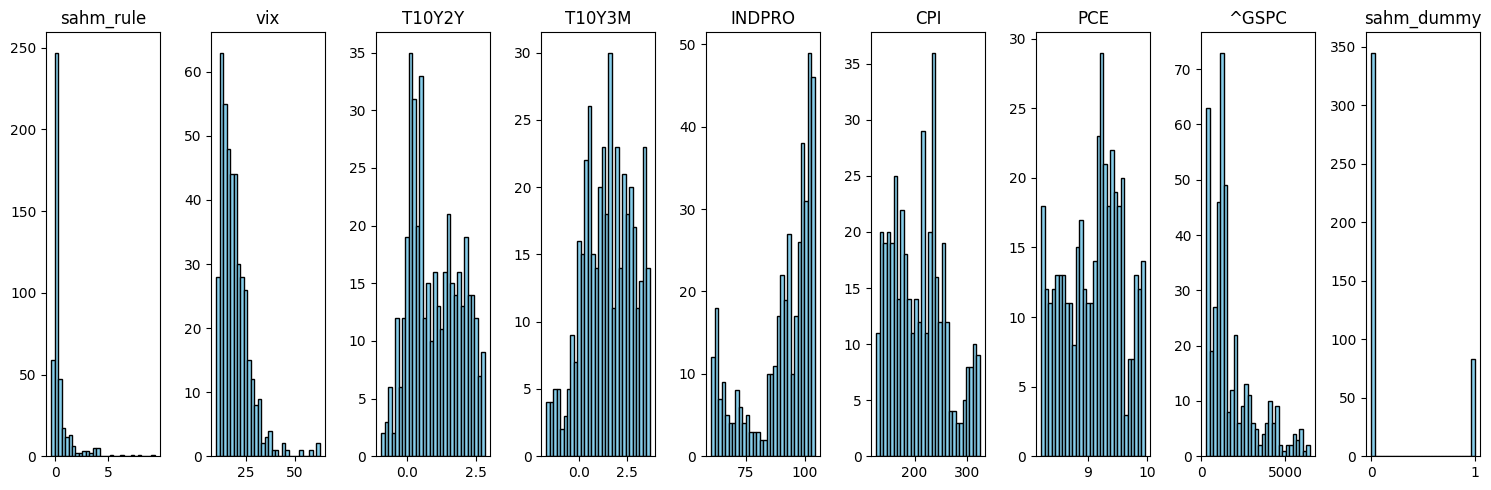

In [13]:
fig, axes = plt.subplots(1, n, figsize=(15,5))

for i, col in enumerate(variables):
    axes[i].hist(data[col], bins=30, color="skyblue", edgecolor="black")
    axes[i].set_title(f"{col}")

plt.tight_layout()
plt.show()

In [14]:
#Modelo Probit
x = data.iloc[:,1:-1]
x = sm.add_constant(x)
y = data.iloc[:,-1]
probit_model = sm.Probit(y, x)
res = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.287837
         Iterations 7


In [15]:
print(res.summary())

                          Probit Regression Results                           
Dep. Variable:             sahm_dummy   No. Observations:                  428
Model:                         Probit   Df Residuals:                      420
Method:                           MLE   Df Model:                            7
Date:              mar., 04 nov. 2025   Pseudo R-squ.:                  0.4148
Time:                        11:51:39   Log-Likelihood:                -123.19
converged:                       True   LL-Null:                       -210.52
Covariance Type:            nonrobust   LLR p-value:                 2.627e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.2992     18.641     -1.894      0.058     -71.835       1.237
vix            0.1014      0.014      7.007      0.000       0.073       0.130
T10Y2Y         0.5844      0.287      2.037      0.0

In [16]:
margeff = res.get_margeff()
print(margeff.summary())

       Probit Marginal Effects       
Dep. Variable:             sahm_dummy
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.0165      0.002      8.431      0.000       0.013       0.020
T10Y2Y         0.0953      0.046      2.091      0.037       0.006       0.185
T10Y3M         0.0317      0.035      0.892      0.372      -0.038       0.101
INDPRO        -0.0191      0.005     -4.233      0.000      -0.028      -0.010
CPI           -0.0066      0.004     -1.740      0.082      -0.014       0.001
PCE            0.8797      0.456      1.931      0.054      -0.013       1.773
^GSPC       9.205e-05   3.54e-05      2.602      0.009    2.27e-05       0.000


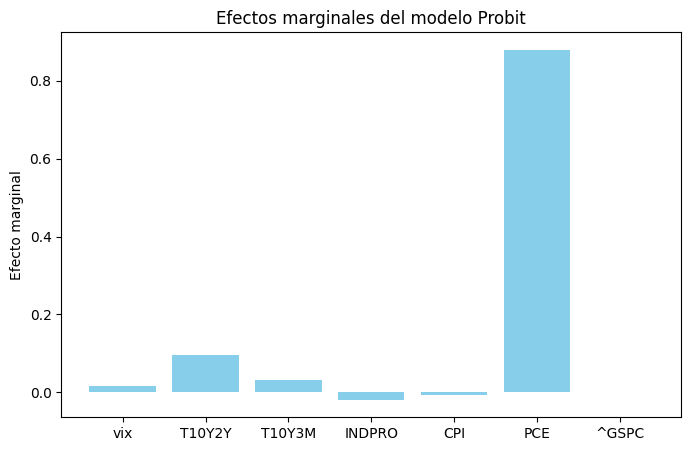

In [17]:
effects = margeff.margeff
variables = x.columns.drop('const')  
plt.figure(figsize=(8,5))
plt.bar(variables, effects, color='skyblue')
plt.ylabel("Efecto marginal")
plt.title("Efectos marginales del modelo Probit")
plt.show()

In [14]:
#estadistica descriptiba

describe_stats = data.describe().T.round(4)

In [15]:
#modelo logit

x_logit = data.iloc[:,1:-1]
x_logit = sm.add_constant(x)
y_logit = data.iloc[:,-1]

In [19]:
logit_model = sm.Logit(y,x)
res_logit = logit_model.fit()
print(res_logit.summary())

Optimization terminated successfully.
         Current function value: 0.283467
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             sahm_dummy   No. Observations:                  428
Model:                          Logit   Df Residuals:                      420
Method:                           MLE   Df Model:                            7
Date:                Fri, 10 Oct 2025   Pseudo R-squ.:                  0.4237
Time:                        12:27:19   Log-Likelihood:                -121.32
converged:                       True   LL-Null:                       -210.52
Covariance Type:            nonrobust   LLR p-value:                 4.264e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -84.6843     36.756     -2.304      0.021    -156.725     -12.644
vix            0.1958      0.

In [21]:
#Resultados log_odds

odds_ratio_logit = np.exp(res_logit.params)
print(odds_ratio_logit)

const     1.667475e-37
vix       1.216263e+00
T10Y2Y    2.179529e+00
T10Y3M    1.730401e+00
INDPRO    7.829158e-01
CPI       9.060441e-01
PCE       4.020363e+05
^GSPC     1.001115e+00
dtype: float64


In [23]:
#Efectos marginales logit

marginal_logit = res_logit.get_margeff()
print(marginal_logit.summary())

        Logit Marginal Effects       
Dep. Variable:             sahm_dummy
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.0174      0.002      8.461      0.000       0.013       0.021
T10Y2Y         0.0691      0.047      1.481      0.139      -0.022       0.161
T10Y3M         0.0486      0.036      1.354      0.176      -0.022       0.119
INDPRO        -0.0217      0.005     -4.630      0.000      -0.031      -0.013
CPI           -0.0088      0.004     -2.200      0.028      -0.017      -0.001
PCE            1.1447      0.480      2.383      0.017       0.203       2.086
^GSPC       9.887e-05   3.51e-05      2.814      0.005       3e-05       0.000
